In [2]:
import sys
import torch
import gym
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [3]:
# Constants
GAMMA = 0.99
EPISODES=1000
num_steps = 200
max_episodes = 3000
RENDER_EVERY = 100
PRINT_EVERY = 50
UPDATE_EVERY=1000
RENDER = True
VERBOSE = True
EPOCH = 8
EPSILON = 0.2
ACTION_SCALER = 2

In [4]:
class Policy(nn.Module):
    
    def __init__(self, num_inputs, learning_rate=.001):
        super(Policy, self).__init__()
        
        self.learning_rate = learning_rate
        self.linear1 = nn.Linear(num_inputs, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 1)
    
    def forward(self, state):
        policy_dist = torch.tanh(self.linear1(state))
        policy_dist = torch.tanh(self.linear2(policy_dist))
        policy_dist = torch.tanh(self.linear3(policy_dist))
        return policy_dist


In [5]:
class Value(nn.Module):

    def __init__(self, num_inputs, learning_rate=.001):
        super(Value, self).__init__()
        
        self.learning_rate = learning_rate
        self.linear1 = nn.Linear(num_inputs, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 1)
    
    def forward(self, state):
        value = torch.tanh(self.linear1(state))
        value = torch.tanh(self.linear2(value)) 
        value = self.linear3(value)

        return value

In [6]:
env = gym.make('Pendulum-v0')
num_inputs = env.observation_space.shape[0]

actor = Policy(num_inputs)
critic = Value(num_inputs)
# Weight Initilization
# actor.linear1.weight =torch.nn.init.uniform_(actor.linear1.weight, a=-3e-3, b=3e-3)
# actor.linear1.bias =torch.nn.init.uniform_(actor.linear1.bias, a=-3e-3, b=3e-3)
# critic.linear1.bias =torch.nn.init.uniform_(critic.linear1.bias, a=-3e-3, b=3e-3)
# critic.linear1.weight =torch.nn.init.uniform_(critic.linear1.weight, a=-3e-3, b=3e-3)

target_actor = Policy(num_inputs)
target_critic = Value(num_inputs)

actor_optimizer = optim.SGD(actor.parameters(), lr=actor.learning_rate)
critic_optimizer = optim.Adam(critic.parameters(), lr=critic.learning_rate)

# torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)

actor.train()
critic.train()
target_actor.eval()
target_critic.eval()

Value(
  (linear1): Linear(in_features=3, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
# critic_objective = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
surrogate_objective = lambda r_theta, advantage: torch.min(torch.mul(r_theta, advantage), torch.mul(torch.clamp(r_theta, 1-EPSILON, 1+EPSILON), advantage))

In [8]:
actor.train()
critic.train()

Value(
  (linear1): Linear(in_features=3, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
def solve(env):
    all_rewards = []
    duration_rewards = []
    
    print('Started Training')

    # collect data
    for episode in range(max_episodes):
        Val_buffer = torch.tensor([])
        reward_buffer = torch.tensor([])
        state_buffer = torch.tensor([])
        action_buffer = torch.tensor([])
        Qval_buffer = torch.tensor([])
        
        current_state = env.reset()
        print('EPISODE: %5d'%(episode), end='\r')

        # Collect Trajectories
        for step in range(num_steps):
            current_state = torch.tensor(current_state).float().unsqueeze(0)
            
            action = actor(current_state) * ACTION_SCALER
            action_buffer = torch.cat((action_buffer, action.detach()))
            state_buffer = torch.cat((state_buffer, current_state))
            next_state, reward, done, _ = env.step(action_buffer[step].numpy())
#             reward = 1 / (( 0.1 - reward)*abs(next_state[2]))

            reward_buffer = torch.cat((reward_buffer, torch.tensor([reward])))
            
            if RENDER and episode%RENDER_EVERY == 0:
                env.render()

            
            Val = critic.forward(current_state)
            Val_buffer = torch.cat((Val_buffer, Val))

            next_state = torch.tensor(next_state).float().unsqueeze(0)
#             next_action = actor(next_state.squeeze())*ACTION_SCALER
            
            Qval = reward_buffer[step] + GAMMA*critic(next_state.squeeze())#.numpy()
            Qval_buffer = torch.cat((Qval_buffer, Qval.detach()))
#             advantage = Qval - Val
            current_state = next_state.squeeze()
            

        for k in range(EPOCH):
            for  itr in range(10):
                state, old_action, reward, Val, Qval = state_buffer[itr*20:itr*20+20], action_buffer[itr*20:itr*20+20], reward_buffer[itr*20:itr*20+20], Val_buffer[itr*20:itr*20+20].squeeze(dim=1), Qval_buffer[itr*20:itr*20+20]
                
                actor_optimizer.zero_grad()
                critic_optimizer.zero_grad()
                
                loss = torch.mean(0.5*torch.pow((Val-Qval),2))
                action = actor(state)*ACTION_SCALER
                loss = torch.mean((surrogate_objective((action / old_action).squeeze(dim=1), (Qval-Val).detach())))
                
#                 print(loss.shape)
                
                loss.backward(retain_graph=True)
                
                actor_optimizer.step()                
                critic_optimizer.step()
       
        torch.save(actor.state_dict(), './actor.pth')
        
        
        target_actor.load_state_dict(actor.state_dict())
        target_actor.eval()
        
        duration_rewards = np.append(duration_rewards, torch.sum(reward_buffer))
        
        if VERBOSE and episode % PRINT_EVERY == 0:                    
            print("Episode: %5d | Reward: %5.0f | Mean Reward: %5.0f"%(episode, torch.sum(reward_buffer), np.mean(duration_rewards)))
            all_rewards = np.append(all_rewards, duration_rewards)
            duration_rewards = []
            plt.plot(all_rewards)
            plt.show()

env.close()

Started Training


/home/rex/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode:     0 | Reward: -1494 | Mean Reward: -1494


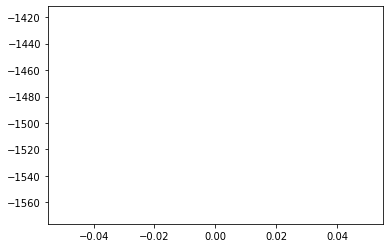

Episode:    50 | Reward: -1654 | Mean Reward: -1466


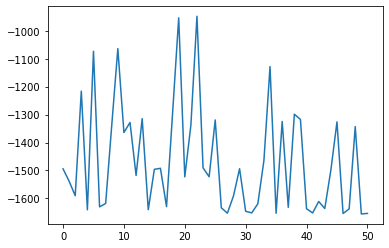

In [ ]:
solve(env)

In [15]:
env.close()

In [16]:
# #Ornstein-Uhlenbeck Process Noise
# th = 1;
# mu = 1.2;
# sig = 0.3;
# dt = 1e-2;
# # t = 0:dt:2;             % Time vector
# t = np.array([])
# for i in range(int(200/dt)):
#     t = np.append(t,i*dt)
# x = np.zeros((t.shape[0])); # Allocate output vector, set initial condition
# # rng(1);                 # Set random seed
# for i in range((t.shape[0])-1):# 1:length(t)-1
#     x[i+1] = x[i]+th*(mu-x[i])*dt+sig*np.sqrt(dt)*np.random.randn();
# import matplotlib.pyplot as plt

# plt.plot(x);

In [13]:
# def solve(env):

#     for episode in range(max_episodes):
#         log_probs = []
#         values = []
#         rewards = []

#         state = env.reset()

#         for steps in range(num_steps):
            
#             action = actor(state)
#             action = action.detach().numpy()
#             value = critic(state, action)
#             value = value.detach().numpy()[0,0]
            
#             log_prob = torch.log(torch.tensor(action.squeeze(0)))
# #             log_prob = torch.log(action.squeeze(0)[action])
# #             entropy = -np.sum(np.mean(dist) * np.log(dist))
#             next_state, reward, done, _ = env.step(action)
            
#             experience.add((state, action, reward, next_state))
#             batch = experience.sample();
            
#             rewards.append(reward)
# #             values.append(value)
            
# #             log_probs.append(log_prob)
# #             entropy_term += entropy
#             state = next_state.squeeze()
            
#             if RENDER and episode%RENDER_EVERY == 0:
#                 env.render()
                
            
#             if batch != None:
#                 for state, action, reward, next_state in batch:

#                     #Update from exp replay batches
# #                     if done or steps == num_steps-1:
#                     next_action = target_actor(next_state.squeeze())
#                     Qval = target_critic.forward(next_state.squeeze(),next_action)
#                     Qval = Qval.detach()#.numpy()#[0,0]
#                     y_hat = Variable(torch.add(torch.tensor(reward), torch.tensor(GAMMA*critic(next_state.squeeze(), next_action))),requires_grad=True)
                    
#                     critic_loss = critic_objective(Qval, y_hat)
#                     critic_optimizer.zero_grad()
#                     critic_loss.backward()
#                     critic_optimizer.step()
                    
#                     actor_loss = actor_objective(next_action, reward)
#                     actor_optimizer.zero_grad()
#                     actor_loss.backward()
#                     actor_optimizer.step()
#                 # compute Q values
# #                 Qvals = np.zeros_like(values)
# #                 for t in reversed(range(len(rewards))):
# #                     Qval = rewards[t] + GAMMA * Qval
# #                     Qvals[t] = Qval

#                 #update actor critic
# #                  values = torch.FloatTensor(values)
# #                 Qvals = torch.FloatTensor(Qvals)
# #                 log_probs = torch.stack(log_probs)

# #                 advantage = Qvals - values
# #                 actor_loss = Variable((-torch.tensor(log_probs) * advantage).mean(),requires_grad=True)
# #                 critic_loss = Variable(0.5 * advantage.pow(2).mean(),requires_grad=True)
# #         #         ac_loss = actor_loss + critic_loss# + 0.001 * entropy_term

# #                 actor_optimizer.zero_grad()
# #                 actor_loss.backward()
# #                 actor_optimizer.step()

# #                 critic_optimizer.zero_grad()
# #                 critic_loss.backward()
# #                 critic_optimizer.step()
            
#             target_actor.update(actor,Tou)
#         print('>')
#         all_rewards.append(np.sum(rewards))
#         all_lengths.append(steps)
#         average_lengths.append(np.mean(all_lengths[-10:]))
#         if VERBOSE and episode % PRINT_EVERY == 0:                    
#             print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
            

#     #         avg_reward += ep_reward
#     #     reward_buffer = np.append(reward_buffer, ep_reward)    
#     #     avg_loss += running_loss
#     # #     env.close()

#     #     if episode%10 == 0:
#     #         print('Episode:',episode,'| Average Loss:',avg_loss/100, '| Epsilon:',epsilon, '| Average Reward:', avg_reward /255)
#     #         avg_loss = 0
#     #         avg_reward = 0
#     #         plt.plot(reward_buffer)
#     #         plt.show()

# env.close()